## Build a Multi-output Model
In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the UCI Machine Learning Repository. It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities
We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data
We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model
Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. [y1_output, y2_output]) when we instantiate the Model() class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

## Configure parameters
We specify the optimizer as well as the loss and metrics for each output.

In [7]:
# Specify the optimizer, and compile the model with loss functions for both outputs
# optimizer = tf.keras.optimizers.SGD(lr=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [8]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 264.7035 - y1_output_loss: 126.4139 - y2_output_loss: 138.2896 - y1_output_root_mean_squared_error: 11.2434 - y2_output_root_mean_squared_error: 11.7597 - val_loss: 46.7928 - val_y1_output_loss: 18.9773 - val_y2_output_loss: 27.8155 - val_y1_output_root_mean_squared_error: 4.3563 - val_y2_output_root_mean_squared_error: 5.2740
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 27.8396 - y1_output_loss: 11.3058 - y2_output_loss: 16.5338 - y1_output_root_mean_squared_error: 3.3624 - y2_output_root_mean_squared_error: 4.0662 - val_loss: 28.8734 - val_y1_output_loss: 13.3714 - val_y2_output_loss: 15.5020 - val_y1_output_root_mean_squared_error: 3.6567 - val_y2_output_root_mean_squared_error: 3.9373
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 24.8024 - y1_output_loss: 9.0542 - y2_output_loss: 15.7482 - y1_output_root_mean_squared_error: 3.0090 - y2_output_root_mean_squ

Epoch 22/500
62/62 [==============================] - 0s 2ms/step - loss: 14.4561 - y1_output_loss: 5.3005 - y2_output_loss: 9.1555 - y1_output_root_mean_squared_error: 2.3023 - y2_output_root_mean_squared_error: 3.0258 - val_loss: 16.5711 - val_y1_output_loss: 7.2878 - val_y2_output_loss: 9.2833 - val_y1_output_root_mean_squared_error: 2.6996 - val_y2_output_root_mean_squared_error: 3.0468
Epoch 23/500
62/62 [==============================] - 0s 2ms/step - loss: 13.4133 - y1_output_loss: 4.7905 - y2_output_loss: 8.6228 - y1_output_root_mean_squared_error: 2.1887 - y2_output_root_mean_squared_error: 2.9365 - val_loss: 15.4501 - val_y1_output_loss: 6.8859 - val_y2_output_loss: 8.5642 - val_y1_output_root_mean_squared_error: 2.6241 - val_y2_output_root_mean_squared_error: 2.9265
Epoch 24/500
62/62 [==============================] - 0s 2ms/step - loss: 17.6358 - y1_output_loss: 5.9135 - y2_output_loss: 11.7223 - y1_output_root_mean_squared_error: 2.4318 - y2_output_root_mean_squared_error

Epoch 43/500
62/62 [==============================] - 0s 2ms/step - loss: 9.7407 - y1_output_loss: 3.2567 - y2_output_loss: 6.4840 - y1_output_root_mean_squared_error: 1.8046 - y2_output_root_mean_squared_error: 2.5464 - val_loss: 9.9255 - val_y1_output_loss: 3.7633 - val_y2_output_loss: 6.1622 - val_y1_output_root_mean_squared_error: 1.9399 - val_y2_output_root_mean_squared_error: 2.4824
Epoch 44/500
62/62 [==============================] - 0s 2ms/step - loss: 8.7640 - y1_output_loss: 2.9822 - y2_output_loss: 5.7818 - y1_output_root_mean_squared_error: 1.7269 - y2_output_root_mean_squared_error: 2.4045 - val_loss: 18.4145 - val_y1_output_loss: 5.9550 - val_y2_output_loss: 12.4595 - val_y1_output_root_mean_squared_error: 2.4403 - val_y2_output_root_mean_squared_error: 3.5298
Epoch 45/500
62/62 [==============================] - 0s 2ms/step - loss: 8.3448 - y1_output_loss: 2.7571 - y2_output_loss: 5.5877 - y1_output_root_mean_squared_error: 1.6604 - y2_output_root_mean_squared_error: 2.

Epoch 64/500
62/62 [==============================] - 0s 2ms/step - loss: 5.9002 - y1_output_loss: 1.7851 - y2_output_loss: 4.1151 - y1_output_root_mean_squared_error: 1.3361 - y2_output_root_mean_squared_error: 2.0286 - val_loss: 8.9088 - val_y1_output_loss: 2.8993 - val_y2_output_loss: 6.0094 - val_y1_output_root_mean_squared_error: 1.7027 - val_y2_output_root_mean_squared_error: 2.4514
Epoch 65/500
62/62 [==============================] - 0s 2ms/step - loss: 6.7543 - y1_output_loss: 1.9965 - y2_output_loss: 4.7578 - y1_output_root_mean_squared_error: 1.4130 - y2_output_root_mean_squared_error: 2.1812 - val_loss: 7.7155 - val_y1_output_loss: 2.2182 - val_y2_output_loss: 5.4973 - val_y1_output_root_mean_squared_error: 1.4894 - val_y2_output_root_mean_squared_error: 2.3446
Epoch 66/500
62/62 [==============================] - 0s 2ms/step - loss: 7.6373 - y1_output_loss: 2.4282 - y2_output_loss: 5.2091 - y1_output_root_mean_squared_error: 1.5583 - y2_output_root_mean_squared_error: 2.28

Epoch 85/500
62/62 [==============================] - 0s 2ms/step - loss: 4.0011 - y1_output_loss: 0.8949 - y2_output_loss: 3.1062 - y1_output_root_mean_squared_error: 0.9460 - y2_output_root_mean_squared_error: 1.7624 - val_loss: 4.9586 - val_y1_output_loss: 1.5390 - val_y2_output_loss: 3.4196 - val_y1_output_root_mean_squared_error: 1.2406 - val_y2_output_root_mean_squared_error: 1.8492
Epoch 86/500
62/62 [==============================] - 0s 2ms/step - loss: 4.7889 - y1_output_loss: 1.2035 - y2_output_loss: 3.5854 - y1_output_root_mean_squared_error: 1.0971 - y2_output_root_mean_squared_error: 1.8935 - val_loss: 8.0471 - val_y1_output_loss: 2.1924 - val_y2_output_loss: 5.8547 - val_y1_output_root_mean_squared_error: 1.4807 - val_y2_output_root_mean_squared_error: 2.4197
Epoch 87/500
62/62 [==============================] - 0s 2ms/step - loss: 3.5708 - y1_output_loss: 0.9208 - y2_output_loss: 2.6500 - y1_output_root_mean_squared_error: 0.9596 - y2_output_root_mean_squared_error: 1.62

Epoch 106/500
62/62 [==============================] - 0s 2ms/step - loss: 3.0609 - y1_output_loss: 0.6740 - y2_output_loss: 2.3869 - y1_output_root_mean_squared_error: 0.8210 - y2_output_root_mean_squared_error: 1.5450 - val_loss: 123.6426 - val_y1_output_loss: 42.8215 - val_y2_output_loss: 80.8211 - val_y1_output_root_mean_squared_error: 6.5438 - val_y2_output_root_mean_squared_error: 8.9901
Epoch 107/500
62/62 [==============================] - 0s 2ms/step - loss: 6.9012 - y1_output_loss: 2.2892 - y2_output_loss: 4.6120 - y1_output_root_mean_squared_error: 1.5130 - y2_output_root_mean_squared_error: 2.1476 - val_loss: 4.8134 - val_y1_output_loss: 0.8065 - val_y2_output_loss: 4.0069 - val_y1_output_root_mean_squared_error: 0.8981 - val_y2_output_root_mean_squared_error: 2.0017
Epoch 108/500
62/62 [==============================] - 0s 2ms/step - loss: 3.0353 - y1_output_loss: 0.6861 - y2_output_loss: 2.3492 - y1_output_root_mean_squared_error: 0.8283 - y2_output_root_mean_squared_erro

Epoch 127/500
62/62 [==============================] - 0s 2ms/step - loss: 2.9809 - y1_output_loss: 0.6914 - y2_output_loss: 2.2895 - y1_output_root_mean_squared_error: 0.8315 - y2_output_root_mean_squared_error: 1.5131 - val_loss: 5.8856 - val_y1_output_loss: 1.0422 - val_y2_output_loss: 4.8434 - val_y1_output_root_mean_squared_error: 1.0209 - val_y2_output_root_mean_squared_error: 2.2008
Epoch 128/500
62/62 [==============================] - 0s 2ms/step - loss: 2.1199 - y1_output_loss: 0.3744 - y2_output_loss: 1.7455 - y1_output_root_mean_squared_error: 0.6119 - y2_output_root_mean_squared_error: 1.3212 - val_loss: 3.4264 - val_y1_output_loss: 0.9146 - val_y2_output_loss: 2.5117 - val_y1_output_root_mean_squared_error: 0.9564 - val_y2_output_root_mean_squared_error: 1.5848
Epoch 129/500
62/62 [==============================] - 0s 2ms/step - loss: 1.9936 - y1_output_loss: 0.4180 - y2_output_loss: 1.5756 - y1_output_root_mean_squared_error: 0.6466 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 2ms/step - loss: 2.1665 - y1_output_loss: 0.3814 - y2_output_loss: 1.7851 - y1_output_root_mean_squared_error: 0.6176 - y2_output_root_mean_squared_error: 1.3361 - val_loss: 2.7381 - val_y1_output_loss: 0.4827 - val_y2_output_loss: 2.2554 - val_y1_output_root_mean_squared_error: 0.6948 - val_y2_output_root_mean_squared_error: 1.5018
Epoch 149/500
62/62 [==============================] - 0s 2ms/step - loss: 2.4339 - y1_output_loss: 0.5231 - y2_output_loss: 1.9108 - y1_output_root_mean_squared_error: 0.7233 - y2_output_root_mean_squared_error: 1.3823 - val_loss: 4.3790 - val_y1_output_loss: 1.1107 - val_y2_output_loss: 3.2682 - val_y1_output_root_mean_squared_error: 1.0539 - val_y2_output_root_mean_squared_error: 1.8078
Epoch 150/500
62/62 [==============================] - 0s 2ms/step - loss: 1.8573 - y1_output_loss: 0.4309 - y2_output_loss: 1.4264 - y1_output_root_mean_squared_error: 0.6564 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 2ms/step - loss: 1.7519 - y1_output_loss: 0.3624 - y2_output_loss: 1.3895 - y1_output_root_mean_squared_error: 0.6020 - y2_output_root_mean_squared_error: 1.1788 - val_loss: 4.4430 - val_y1_output_loss: 1.3735 - val_y2_output_loss: 3.0694 - val_y1_output_root_mean_squared_error: 1.1720 - val_y2_output_root_mean_squared_error: 1.7520
Epoch 170/500
62/62 [==============================] - 0s 2ms/step - loss: 2.3281 - y1_output_loss: 0.4719 - y2_output_loss: 1.8562 - y1_output_root_mean_squared_error: 0.6870 - y2_output_root_mean_squared_error: 1.3624 - val_loss: 4.2962 - val_y1_output_loss: 1.0904 - val_y2_output_loss: 3.2059 - val_y1_output_root_mean_squared_error: 1.0442 - val_y2_output_root_mean_squared_error: 1.7905
Epoch 171/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5548 - y1_output_loss: 0.2890 - y2_output_loss: 1.2659 - y1_output_root_mean_squared_error: 0.5376 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 2ms/step - loss: 2.0464 - y1_output_loss: 0.3808 - y2_output_loss: 1.6656 - y1_output_root_mean_squared_error: 0.6171 - y2_output_root_mean_squared_error: 1.2906 - val_loss: 2.1148 - val_y1_output_loss: 0.5164 - val_y2_output_loss: 1.5984 - val_y1_output_root_mean_squared_error: 0.7186 - val_y2_output_root_mean_squared_error: 1.2643
Epoch 191/500
62/62 [==============================] - 0s 2ms/step - loss: 1.4347 - y1_output_loss: 0.2522 - y2_output_loss: 1.1825 - y1_output_root_mean_squared_error: 0.5022 - y2_output_root_mean_squared_error: 1.0874 - val_loss: 2.5513 - val_y1_output_loss: 0.3883 - val_y2_output_loss: 2.1630 - val_y1_output_root_mean_squared_error: 0.6231 - val_y2_output_root_mean_squared_error: 1.4707
Epoch 192/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1415 - y1_output_loss: 0.2057 - y2_output_loss: 0.9359 - y1_output_root_mean_squared_error: 0.4535 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0687 - y1_output_loss: 0.1848 - y2_output_loss: 0.8838 - y1_output_root_mean_squared_error: 0.4299 - y2_output_root_mean_squared_error: 0.9401 - val_loss: 1.6763 - val_y1_output_loss: 0.4297 - val_y2_output_loss: 1.2466 - val_y1_output_root_mean_squared_error: 0.6555 - val_y2_output_root_mean_squared_error: 1.1165
Epoch 212/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9323 - y1_output_loss: 0.1844 - y2_output_loss: 0.7479 - y1_output_root_mean_squared_error: 0.4294 - y2_output_root_mean_squared_error: 0.8648 - val_loss: 2.1386 - val_y1_output_loss: 0.4829 - val_y2_output_loss: 1.6557 - val_y1_output_root_mean_squared_error: 0.6949 - val_y2_output_root_mean_squared_error: 1.2867
Epoch 213/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0950 - y1_output_loss: 0.1877 - y2_output_loss: 0.9073 - y1_output_root_mean_squared_error: 0.4333 - y2_output_root_mean_squared_error: 0

Epoch 232/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0476 - y1_output_loss: 0.1884 - y2_output_loss: 0.8593 - y1_output_root_mean_squared_error: 0.4340 - y2_output_root_mean_squared_error: 0.9270 - val_loss: 6.4377 - val_y1_output_loss: 1.7354 - val_y2_output_loss: 4.7022 - val_y1_output_root_mean_squared_error: 1.3174 - val_y2_output_root_mean_squared_error: 2.1685
Epoch 233/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3152 - y1_output_loss: 0.2335 - y2_output_loss: 1.0817 - y1_output_root_mean_squared_error: 0.4832 - y2_output_root_mean_squared_error: 1.0401 - val_loss: 1.5109 - val_y1_output_loss: 0.3107 - val_y2_output_loss: 1.2002 - val_y1_output_root_mean_squared_error: 0.5574 - val_y2_output_root_mean_squared_error: 1.0956
Epoch 234/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9639 - y1_output_loss: 0.1789 - y2_output_loss: 0.7850 - y1_output_root_mean_squared_error: 0.4230 - y2_output_root_mean_squared_error: 0

Epoch 253/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7768 - y1_output_loss: 0.1532 - y2_output_loss: 0.6236 - y1_output_root_mean_squared_error: 0.3914 - y2_output_root_mean_squared_error: 0.7897 - val_loss: 1.4340 - val_y1_output_loss: 0.3605 - val_y2_output_loss: 1.0735 - val_y1_output_root_mean_squared_error: 0.6004 - val_y2_output_root_mean_squared_error: 1.0361
Epoch 254/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7372 - y1_output_loss: 0.1311 - y2_output_loss: 0.6061 - y1_output_root_mean_squared_error: 0.3621 - y2_output_root_mean_squared_error: 0.7785 - val_loss: 7.1937 - val_y1_output_loss: 1.9989 - val_y2_output_loss: 5.1948 - val_y1_output_root_mean_squared_error: 1.4138 - val_y2_output_root_mean_squared_error: 2.2792
Epoch 255/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8226 - y1_output_loss: 0.1836 - y2_output_loss: 0.6390 - y1_output_root_mean_squared_error: 0.4285 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8180 - y1_output_loss: 0.1436 - y2_output_loss: 0.6744 - y1_output_root_mean_squared_error: 0.3790 - y2_output_root_mean_squared_error: 0.8212 - val_loss: 1.5714 - val_y1_output_loss: 0.3945 - val_y2_output_loss: 1.1769 - val_y1_output_root_mean_squared_error: 0.6281 - val_y2_output_root_mean_squared_error: 1.0848
Epoch 275/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7419 - y1_output_loss: 0.1646 - y2_output_loss: 0.5773 - y1_output_root_mean_squared_error: 0.4057 - y2_output_root_mean_squared_error: 0.7598 - val_loss: 1.2789 - val_y1_output_loss: 0.2953 - val_y2_output_loss: 0.9836 - val_y1_output_root_mean_squared_error: 0.5434 - val_y2_output_root_mean_squared_error: 0.9918
Epoch 276/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7852 - y1_output_loss: 0.1561 - y2_output_loss: 0.6291 - y1_output_root_mean_squared_error: 0.3951 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6691 - y1_output_loss: 0.1302 - y2_output_loss: 0.5389 - y1_output_root_mean_squared_error: 0.3608 - y2_output_root_mean_squared_error: 0.7341 - val_loss: 1.7107 - val_y1_output_loss: 0.4834 - val_y2_output_loss: 1.2274 - val_y1_output_root_mean_squared_error: 0.6952 - val_y2_output_root_mean_squared_error: 1.1079
Epoch 296/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0512 - y1_output_loss: 0.2071 - y2_output_loss: 0.8442 - y1_output_root_mean_squared_error: 0.4550 - y2_output_root_mean_squared_error: 0.9188 - val_loss: 1.3318 - val_y1_output_loss: 0.3108 - val_y2_output_loss: 1.0211 - val_y1_output_root_mean_squared_error: 0.5575 - val_y2_output_root_mean_squared_error: 1.0105
Epoch 297/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6170 - y1_output_loss: 0.1320 - y2_output_loss: 0.4850 - y1_output_root_mean_squared_error: 0.3633 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6428 - y1_output_loss: 0.1384 - y2_output_loss: 0.5044 - y1_output_root_mean_squared_error: 0.3720 - y2_output_root_mean_squared_error: 0.7102 - val_loss: 1.3410 - val_y1_output_loss: 0.3399 - val_y2_output_loss: 1.0011 - val_y1_output_root_mean_squared_error: 0.5830 - val_y2_output_root_mean_squared_error: 1.0005
Epoch 317/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5758 - y1_output_loss: 0.1298 - y2_output_loss: 0.4461 - y1_output_root_mean_squared_error: 0.3602 - y2_output_root_mean_squared_error: 0.6679 - val_loss: 2.5397 - val_y1_output_loss: 0.3902 - val_y2_output_loss: 2.1496 - val_y1_output_root_mean_squared_error: 0.6246 - val_y2_output_root_mean_squared_error: 1.4661
Epoch 318/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5610 - y1_output_loss: 0.1263 - y2_output_loss: 0.4348 - y1_output_root_mean_squared_error: 0.3553 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6718 - y1_output_loss: 0.1422 - y2_output_loss: 0.5296 - y1_output_root_mean_squared_error: 0.3771 - y2_output_root_mean_squared_error: 0.7278 - val_loss: 1.1225 - val_y1_output_loss: 0.3144 - val_y2_output_loss: 0.8081 - val_y1_output_root_mean_squared_error: 0.5607 - val_y2_output_root_mean_squared_error: 0.8990
Epoch 338/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6111 - y1_output_loss: 0.1392 - y2_output_loss: 0.4719 - y1_output_root_mean_squared_error: 0.3731 - y2_output_root_mean_squared_error: 0.6869 - val_loss: 1.9702 - val_y1_output_loss: 0.5190 - val_y2_output_loss: 1.4512 - val_y1_output_root_mean_squared_error: 0.7204 - val_y2_output_root_mean_squared_error: 1.2047
Epoch 339/500
62/62 [==============================] - 0s 2ms/step - loss: 0.8210 - y1_output_loss: 0.1794 - y2_output_loss: 0.6416 - y1_output_root_mean_squared_error: 0.4236 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6278 - y1_output_loss: 0.1456 - y2_output_loss: 0.4822 - y1_output_root_mean_squared_error: 0.3816 - y2_output_root_mean_squared_error: 0.6944 - val_loss: 1.0998 - val_y1_output_loss: 0.2760 - val_y2_output_loss: 0.8238 - val_y1_output_root_mean_squared_error: 0.5253 - val_y2_output_root_mean_squared_error: 0.9076
Epoch 359/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4964 - y1_output_loss: 0.1282 - y2_output_loss: 0.3683 - y1_output_root_mean_squared_error: 0.3580 - y2_output_root_mean_squared_error: 0.6068 - val_loss: 1.1019 - val_y1_output_loss: 0.2985 - val_y2_output_loss: 0.8034 - val_y1_output_root_mean_squared_error: 0.5464 - val_y2_output_root_mean_squared_error: 0.8963
Epoch 360/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5230 - y1_output_loss: 0.1325 - y2_output_loss: 0.3905 - y1_output_root_mean_squared_error: 0.3641 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4737 - y1_output_loss: 0.1102 - y2_output_loss: 0.3635 - y1_output_root_mean_squared_error: 0.3319 - y2_output_root_mean_squared_error: 0.6029 - val_loss: 1.6921 - val_y1_output_loss: 0.4120 - val_y2_output_loss: 1.2800 - val_y1_output_root_mean_squared_error: 0.6419 - val_y2_output_root_mean_squared_error: 1.1314
Epoch 380/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4944 - y1_output_loss: 0.1128 - y2_output_loss: 0.3815 - y1_output_root_mean_squared_error: 0.3359 - y2_output_root_mean_squared_error: 0.6177 - val_loss: 1.0997 - val_y1_output_loss: 0.2797 - val_y2_output_loss: 0.8200 - val_y1_output_root_mean_squared_error: 0.5289 - val_y2_output_root_mean_squared_error: 0.9055
Epoch 381/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4196 - y1_output_loss: 0.0957 - y2_output_loss: 0.3239 - y1_output_root_mean_squared_error: 0.3093 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4129 - y1_output_loss: 0.1068 - y2_output_loss: 0.3061 - y1_output_root_mean_squared_error: 0.3269 - y2_output_root_mean_squared_error: 0.5533 - val_loss: 1.2276 - val_y1_output_loss: 0.3493 - val_y2_output_loss: 0.8783 - val_y1_output_root_mean_squared_error: 0.5910 - val_y2_output_root_mean_squared_error: 0.9372
Epoch 401/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4139 - y1_output_loss: 0.1049 - y2_output_loss: 0.3090 - y1_output_root_mean_squared_error: 0.3239 - y2_output_root_mean_squared_error: 0.5559 - val_loss: 2.4009 - val_y1_output_loss: 0.3978 - val_y2_output_loss: 2.0031 - val_y1_output_root_mean_squared_error: 0.6307 - val_y2_output_root_mean_squared_error: 1.4153
Epoch 402/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4479 - y1_output_loss: 0.1032 - y2_output_loss: 0.3447 - y1_output_root_mean_squared_error: 0.3212 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5087 - y1_output_loss: 0.1294 - y2_output_loss: 0.3793 - y1_output_root_mean_squared_error: 0.3597 - y2_output_root_mean_squared_error: 0.6159 - val_loss: 1.0049 - val_y1_output_loss: 0.2741 - val_y2_output_loss: 0.7308 - val_y1_output_root_mean_squared_error: 0.5235 - val_y2_output_root_mean_squared_error: 0.8548
Epoch 422/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5232 - y1_output_loss: 0.1201 - y2_output_loss: 0.4031 - y1_output_root_mean_squared_error: 0.3465 - y2_output_root_mean_squared_error: 0.6349 - val_loss: 1.2071 - val_y1_output_loss: 0.3229 - val_y2_output_loss: 0.8841 - val_y1_output_root_mean_squared_error: 0.5683 - val_y2_output_root_mean_squared_error: 0.9403
Epoch 423/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4047 - y1_output_loss: 0.1033 - y2_output_loss: 0.3013 - y1_output_root_mean_squared_error: 0.3214 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5922 - y1_output_loss: 0.1541 - y2_output_loss: 0.4382 - y1_output_root_mean_squared_error: 0.3925 - y2_output_root_mean_squared_error: 0.6619 - val_loss: 0.9929 - val_y1_output_loss: 0.2978 - val_y2_output_loss: 0.6951 - val_y1_output_root_mean_squared_error: 0.5457 - val_y2_output_root_mean_squared_error: 0.8337
Epoch 443/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4548 - y1_output_loss: 0.1307 - y2_output_loss: 0.3240 - y1_output_root_mean_squared_error: 0.3616 - y2_output_root_mean_squared_error: 0.5692 - val_loss: 1.0218 - val_y1_output_loss: 0.2650 - val_y2_output_loss: 0.7568 - val_y1_output_root_mean_squared_error: 0.5148 - val_y2_output_root_mean_squared_error: 0.8699
Epoch 444/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4102 - y1_output_loss: 0.1015 - y2_output_loss: 0.3086 - y1_output_root_mean_squared_error: 0.3186 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3323 - y1_output_loss: 0.0865 - y2_output_loss: 0.2457 - y1_output_root_mean_squared_error: 0.2942 - y2_output_root_mean_squared_error: 0.4957 - val_loss: 0.9774 - val_y1_output_loss: 0.3045 - val_y2_output_loss: 0.6729 - val_y1_output_root_mean_squared_error: 0.5518 - val_y2_output_root_mean_squared_error: 0.8203
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4384 - y1_output_loss: 0.1179 - y2_output_loss: 0.3205 - y1_output_root_mean_squared_error: 0.3434 - y2_output_root_mean_squared_error: 0.5661 - val_loss: 1.7326 - val_y1_output_loss: 0.3374 - val_y2_output_loss: 1.3952 - val_y1_output_root_mean_squared_error: 0.5808 - val_y2_output_root_mean_squared_error: 1.1812
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3850 - y1_output_loss: 0.1082 - y2_output_loss: 0.2768 - y1_output_root_mean_squared_error: 0.3290 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4052 - y1_output_loss: 0.1067 - y2_output_loss: 0.2985 - y1_output_root_mean_squared_error: 0.3266 - y2_output_root_mean_squared_error: 0.5464 - val_loss: 1.4802 - val_y1_output_loss: 0.3323 - val_y2_output_loss: 1.1478 - val_y1_output_root_mean_squared_error: 0.5765 - val_y2_output_root_mean_squared_error: 1.0714
Epoch 485/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6017 - y1_output_loss: 0.1354 - y2_output_loss: 0.4664 - y1_output_root_mean_squared_error: 0.3679 - y2_output_root_mean_squared_error: 0.6829 - val_loss: 0.9461 - val_y1_output_loss: 0.2704 - val_y2_output_loss: 0.6757 - val_y1_output_root_mean_squared_error: 0.5200 - val_y2_output_root_mean_squared_error: 0.8220
Epoch 486/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3298 - y1_output_loss: 0.0982 - y2_output_loss: 0.2316 - y1_output_root_mean_squared_error: 0.3134 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 1.5882 - y1_output_loss: 0.2881 - y2_output_loss: 1.3001 - y1_output_root_mean_squared_error: 0.5367 - y2_output_root_mean_squared_error: 1.1402
Loss = 1.5881822109222412, Y1_loss = 0.28805026412010193, Y1_mse = 0.5367031693458557, Y2_loss = 1.300131916999817, Y2_mse = 1.1402332782745361


5/5 [==============================] - 0s 3ms/step


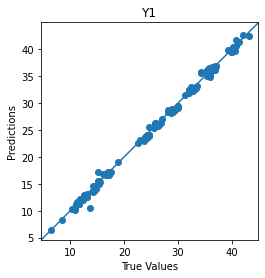

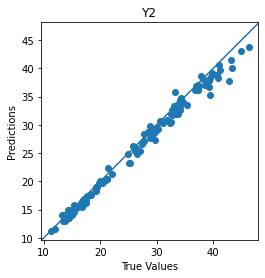

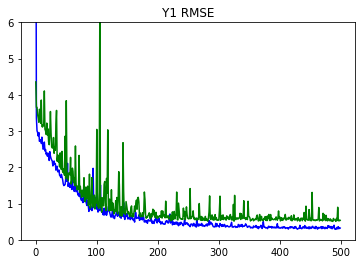

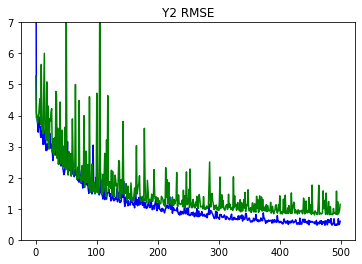

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)